In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import root
#from scipy.optimize import minimize
import uncertainties

In [2]:
from scipy.constants import e

## Reading, first calculations from data and adding uncertainties

In [3]:
#einlesen
df=pd.read_csv("data_e092.csv")
df.head()

,R_temp1_ohm,1a_mV,1b_mV,2a_mV,2b_mV,R_temp2_ohm,3a_0_mV,3a_B_mV,3b_B_mV,3b_0_mV
0,108.443,25.673,-25.687,11.630,-11.640,108.442,14.0,3.953,-3.972,-14.017
1,108.442,25.672,-25.688,11.626,-11.637,108.442,14.0,3.955,-3.968,-14.017
2,108.442,25.672,-25.688,11.626,-11.638,108.442,14.0,3.955,-3.996,-14.017
3,108.442,25.673,-25.688,11.627,-11.638,108.442,14.0,3.954,-3.970,-14.016
4,108.442,25.673,-25.687,11.627,-11.638,108.442,14.0,3.954,-3.969,-14.017


In [4]:
#transdencent function for rho
def transcendent_function(f, x):
    return np.cosh(np.log(2)/f * (x-1)/(x+1)) - 0.5*np.exp(np.log(2)/f)

In [5]:
# remove the bad values, i.e. in german: "Ausreißer"
df = df.drop([66-15,66-16,66-17,66-18, 66-22, 66-25])

In [6]:
df = df.reset_index()

In [7]:
#temperature with uncertainty
def get_temp_uncert(T):
    new_T=[]
    for t in range(len(T)):
        if T[t]>70:
            new_T.append(uncertainties.ufloat(T[t], abs(T[t])*0.002))
        else:
            new_T.append(uncertainties.ufloat(T[t], abs(T[t])*0.01))
    return np.array(new_T)
#define thickness
d = uncertainties.ufloat(500e-6, 1e-6)
#temperature conversion in K
T_1 = 509/8 - 89/2/df["R_temp1_ohm"] + 43/30*np.sqrt(df["R_temp1_ohm"]) + 161/113*df["R_temp1_ohm"]**1.1
T_2 = 509/8 - 89/2/df["R_temp2_ohm"] + 43/30*np.sqrt(df["R_temp2_ohm"]) + 161/113*df["R_temp2_ohm"]**1.1
#adding uncertainties to temperature
T_1=get_temp_uncert(T_1)
T_2=get_temp_uncert(T_2)

In [9]:
#define the voltages and add uncertainty of 0.5
#TODO: get_uncertainty_function


def get_uncertainty_function(array):
    new_array=[]
    for i in range(len(array)):
        new_array.append(uncertainties.ufloat(array[i], 0.05)) #adding uncertainty of 0.05mV
    return np.array(new_array)

U_1a = get_uncertainty_function(df["1a_mV"])
U_1b = get_uncertainty_function(df["1b_mV"])
U_2a = get_uncertainty_function(df["2a_mV"])
U_2b = get_uncertainty_function(df["2b_mV"])
U_3a_0 = get_uncertainty_function(df["3a_0_mV"])
U_3b_0 = get_uncertainty_function(df["3b_0_mV"])
U_3a_B = get_uncertainty_function(df["3a_B_mV"])
U_3b_B = get_uncertainty_function(df["3b_B_mV"])

In [10]:
#compute the resistance
rho1=[]
for i in range(len(df["R_temp1_ohm"])):
    #Current of 500uA = 0.5mA
    R_abcd = (abs(df["1a_mV"][i]/0.5) + abs(df["1b_mV"][i]/(-0.5)))/2 #both current directions
    R_bcda = (abs(df["2a_mV"][i]/0.5) + abs(df["2b_mV"][i]/(-0.5)))/2 #both current directions
    x=R_abcd/R_bcda 
    f = root(transcendent_function, 0.5, args=(x, )).x[0] #finding solution for the transcendent equation

    rho1.append(np.pi * d / np.log(2) *0.5*(R_abcd+R_bcda)*f) #calculating rho in SI units
    rho = np.array(rho1)

In [11]:
#calculating Hall's coefficient
#here discuss if we need negative sing because of the currrent direction
R_acbd_a = df["3a_B_mV"]/0.5
R_acbd_b = df["3b_B_mV"]/(-0.5)
R_H_1 = d/0.2525 * (R_acbd_a - df["3a_0_mV"]/0.5)
R_H_2 = d/0.2525 * (R_acbd_b - df["3b_0_mV"]/(-0.5))
R_H = (R_H_1+R_H_2)/2

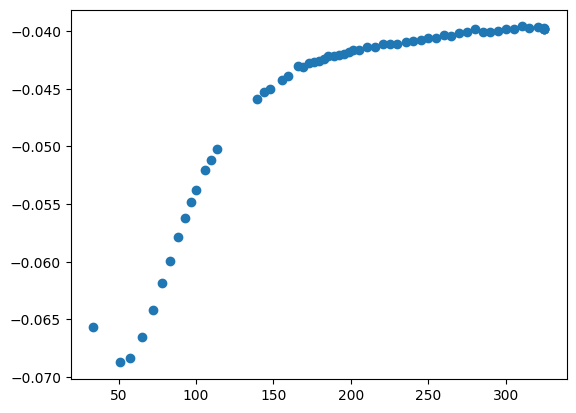

In [12]:
plt.scatter(np.array([T_2[i].n for i in range(len(T_2))]), np.array([R_H[i].n for i in range(len(R_H))]))

## Room temperature

In [13]:
df_RT = df[0:5]
df_RT

,index,R_temp1_ohm,1a_mV,1b_mV,2a_mV,2b_mV,R_temp2_ohm,3a_0_mV,3a_B_mV,3b_B_mV,3b_0_mV
0,0,108.443,25.673,-25.687,11.630,-11.640,108.442,14.0,3.953,-3.972,-14.017
1,1,108.442,25.672,-25.688,11.626,-11.637,108.442,14.0,3.955,-3.968,-14.017
2,2,108.442,25.672,-25.688,11.626,-11.638,108.442,14.0,3.955,-3.996,-14.017
3,3,108.442,25.673,-25.688,11.627,-11.638,108.442,14.0,3.954,-3.970,-14.016
4,4,108.442,25.673,-25.687,11.627,-11.638,108.442,14.0,3.954,-3.969,-14.017


In [14]:
Temp1_RT = T_1[0:5]
Temp2_RT = T_2[0:5]
R_H_RT = R_H[0:5]
rho_RT=rho[0:5]

In [15]:
n_RT = 1/(R_H_RT*(-e))
mu_RT = -R_H_RT/rho_RT

In [16]:
n_RT

0    (1.5688+/-0.0031)e+20
1    (1.5686+/-0.0031)e+20
2    (1.5708+/-0.0031)e+20
3    (1.5688+/-0.0031)e+20
4    (1.5686+/-0.0031)e+20
dtype: object

In [17]:
mu_RT

0    0.49583295193447790572+/-0.00000000000000000006
1    0.49594793169817941170+/-0.00000000000000000006
2    0.49524748940826884835+/-0.00000000000000000011
3    0.49587441024423734026+/-0.00000000000000000011
4    0.49592917956528881351+/-0.00000000000000000023
dtype: object

## Temperature row